In [34]:
%reload_ext autoreload
%autoreload 2

In [35]:
import os, sys, glob

In [36]:
import pandas as pd

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

import matplotlib.ticker as ticker

import matplotlib.dates as mdates

In [37]:
from datetime import datetime, timedelta

### Setup

In [38]:
DATA_DIR = "../data-world/csse_covid_19_data/csse_covid_19_daily_reports"
PLOTS_DIR = "../plots"

## Data loading

In [39]:
csv_files = glob.glob(DATA_DIR + "/*.csv")

In [40]:
csv_files = sorted(csv_files)

In [41]:
def extract_date(file_name):
    date_str = os.path.basename(file_name)[:-4]
    
    date = datetime.strptime(date_str, '%m-%d-%Y').date()
    
    return date

In [42]:
world_df = None

fields_mapping_dic = {
    "Province/State":"Province_State",
    "Country/Region":"Country_Region",
    "Last Update":"Last_Update",
    "Confirmed":"Confirmed",
    "Deaths":"Deaths",
    "Recovered":"Recovered",
    "Latitude":"Lat",
    "Longitude":"Long_"
}

for csv_file in csv_files:
    
    df = pd.read_csv(csv_file)
    date = extract_date(csv_file)
    
    if date >= datetime.strptime("03-23-2020", '%m-%d-%Y').date():
        for k, v in fields_mapping_dic.items():
            df[k] = df[v]
        pass
        
    
    df['Date'] = date
    
    if world_df is None:
        world_df = df
    else:
        world_df = pd.concat((world_df, df), ignore_index=True)

### Setup individual country

In [43]:
# To simulate date up to the 8th of march 2020
# world_df = world_df[world_df['Date'] <= datetime.strptime("03-08-2020", '%m-%d-%Y').date()].copy()

In [44]:
# Uncomment in case you want to check the list of countries with available data

# world_df['Country/Region'].unique()

In [45]:
countries_parameters = dict()

countries_parameters['Italy'] = {
    'ESTIMATED_IC_CAPACITY': 5000,
    'START_DATE': datetime(2020, 2, 23).date()
}

countries_parameters['Sweden'] = {
    'ESTIMATED_IC_CAPACITY': 1000,
    'START_DATE': datetime(2020, 2, 29).date()
}

countries_parameters['United Kingdom'] = {
    'ESTIMATED_IC_CAPACITY': 5000,
    'START_DATE': datetime(2020, 3, 12).date()
}

# countries_parameters['United Kingdom'] = {
#     'ESTIMATED_IC_CAPACITY': 5000,
#     'START_DATE': datetime(2020, 3, 12).date()
# }

In [46]:
country_name = "Italy"

ESTIMATED_IC_CAPACITY = countries_parameters[country_name]['ESTIMATED_IC_CAPACITY']
START_DATE = countries_parameters[country_name]['START_DATE']

In [47]:
def get_country_df(world_df, country_name):
    
    # Some countries have several Provinces/States, must aggregate
    country_df = world_df[world_df['Country/Region'] == country_name] \
        .groupby(["Country/Region", "Date"]) \
        .sum() \
        .sort_values(by='Date')
    
    # Restore columns
    country_df['Country/Region'] = [i[0] for i in country_df.index]
    country_df['Date'] = [i[1] for i in country_df.index]
    
    return country_df
#     return world_df[world_df['Province/State'] == country_name].sort_values(by='Date')

In [48]:
# Get data for a single country, sorted by date
# country_df = world_df[world_df['Country/Region'] == country_name]

country_df = get_country_df(world_df, country_name)

country_df['Increase'] = country_df['Confirmed'].diff()

In [49]:
# Uncomment to check data for a specific day

# country_df[country_df['Date'] == datetime.strptime("03-23-2020", '%m-%d-%Y').date()]

In [50]:
# Check latest data

s = country_df.tail()
country_df.tail()

Confirmed   Deaths  Recovered  Latitude  Longitude  \
Country/Region Date                                                             
Italy          2020-04-07   135586.0  17127.0    24392.0  41.87194   12.56738   
               2020-04-08   139422.0  17669.0    26491.0  41.87194   12.56738   
               2020-04-09   143626.0  18279.0    28470.0  41.87194   12.56738   
               2020-04-10   147577.0  18849.0    30455.0  41.87194   12.56738   
               2020-04-11   152271.0  19468.0    32534.0  41.87194   12.56738   

                           FIPS       Lat     Long_    Active Country/Region  \
Country/Region Date                                                            
Italy          2020-04-07   0.0  41.87194  12.56738   94067.0          Italy   
               2020-04-08   0.0  41.87194  12.56738   95262.0          Italy   
               2020-04-09   0.0  41.87194  12.56738   96877.0          Italy   
               2020-04-10   0.0  41.87194  12.56738   98273.0          Italy   
               2020-04-11   0.0  41.87194  12.56738  100269.0          Italy   

                                 Date  Increase  
Country/Region Date                              
Italy          2020-04-07  2020-04-07    3039.0  
               2020-04-08  2020-04-08    3836.0  
               2020-04-09  2020-04-09    4204.0  
               2020-04-10  2020-04-10    3951.0  
               2020-04-11  2020-04-11    4694.0

Compute daily increase of confirmed cases

In [51]:
# Estimate a reasonable value for Y tick given the maximum number of cases
Y_GRID_TICK = 10**int(np.log10(country_df['Confirmed'].max()))/2

In [52]:
# country_df = country_df[country_df['Date'] <= datetime.strptime("02-28-2020", '%m-%d-%Y').date()]

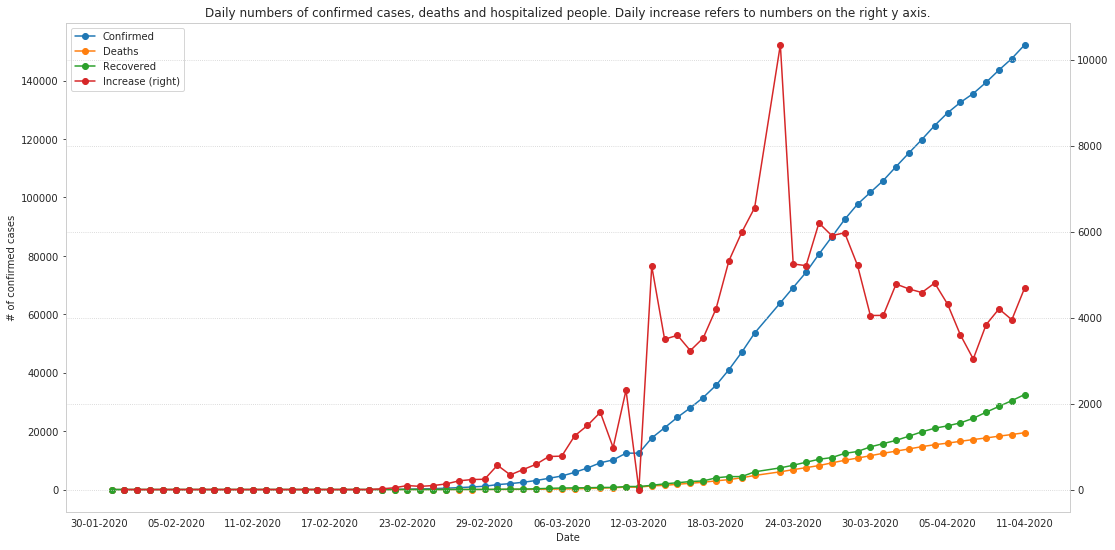

In [53]:
ax = plt.gca()

sns.set_style("whitegrid", {'grid.linestyle': ':'})
# ax.yaxis.set_major_locator(ticker.MultipleLocator(Y_GRID_TICK))
ax.xaxis.set_major_locator(ticker.MultipleLocator(6))

country_df.plot(x='Date', y=["Confirmed", "Deaths", "Recovered"], figsize=(18,9), ax=ax, marker='o')
# country_df.plot(x='Date', y=["Recovered"], figsize=(18,9), ax=ax, marker='o')
country_df.plot(x='Date', y=["Increase"], secondary_y=True, figsize=(18,9), ax=ax, marker='o')



# country_df.plot(x='Date', y=["Recovered"], figsize=(18,9), ax=ax, marker='o')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax.set_ylabel("# of confirmed cases");

ax.set_title("Daily numbers of confirmed cases, deaths and hospitalized people. Daily increase refers to numbers on the right y axis.");

plt.savefig(os.path.join(PLOTS_DIR, "daily_data.png"));

$y = e^{ax}$

$\ln{y} = ax$

## ML analysis

In [54]:
from sklearn.linear_model import LinearRegression, SGDRegressor

from scipy.optimize import curve_fit

In [55]:
# Set range of data to build model

# It might make sense to skip part of the initial points, when the exponential trend was still not evident

### Simple linear fit against log values

In [56]:
# Prepare value vectors

# The acual values
y = country_df[country_df['Date'] >= START_DATE]['Confirmed']

# The log values
y_log = np.log(y)

# Independent variable
x = np.arange(len(y))

In [57]:
reg_unweighted = LinearRegression()
reg_unweighted.fit(x[:,np.newaxis], y_log)

reg_weighted = LinearRegression()
reg_weighted.fit(x[:,np.newaxis], y_log, sample_weight=y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Create dataframe with estimates

In [58]:
# PREDICT_UNTIL = '03/27/2020'
PREDICT_UNTIL = (datetime.today() + timedelta(days=2)).date().strftime("%m/%d/%Y")

estimate_dates = pd.date_range(start=START_DATE.strftime("%m/%d/%Y"), end=PREDICT_UNTIL)
estimate_cases_ols_unweighted = np.exp(reg_unweighted.predict(np.arange(len(estimate_dates))[:, np.newaxis]))
estimate_cases_ols_weighted = np.exp(reg_weighted.predict(np.arange(len(estimate_dates))[:, np.newaxis]))

# Make predictions
# estimate_cases_cf = my_exp(np.arange(len(estimate_dates)), *popt)

# df_estimates = pd.DataFrame({"Date": estimate_dates, "Predictions": estimate_cases})
df_estimates = pd.DataFrame({"Date": estimate_dates, "Predictions (unweighted)": estimate_cases_ols_unweighted, "Predictions (weighted)": estimate_cases_ols_weighted})

### Estimate people in IC

Assume that 7% of infected people require a bed in IC (rough estimate)

In [59]:
# IC coefficient
IC_coefficient = 0.07

country_df['Confirmed_IC'] = country_df['Confirmed']*IC_coefficient
df_estimates['Predictions IC (unweighted)'] = df_estimates['Predictions (unweighted)']*IC_coefficient
df_estimates['Predictions IC (weighted)'] = df_estimates['Predictions (weighted)']*IC_coefficient

# df_estimates['IC caspacity (national)'] = ESTIMATED_IC_CAPACITY

### Plot results

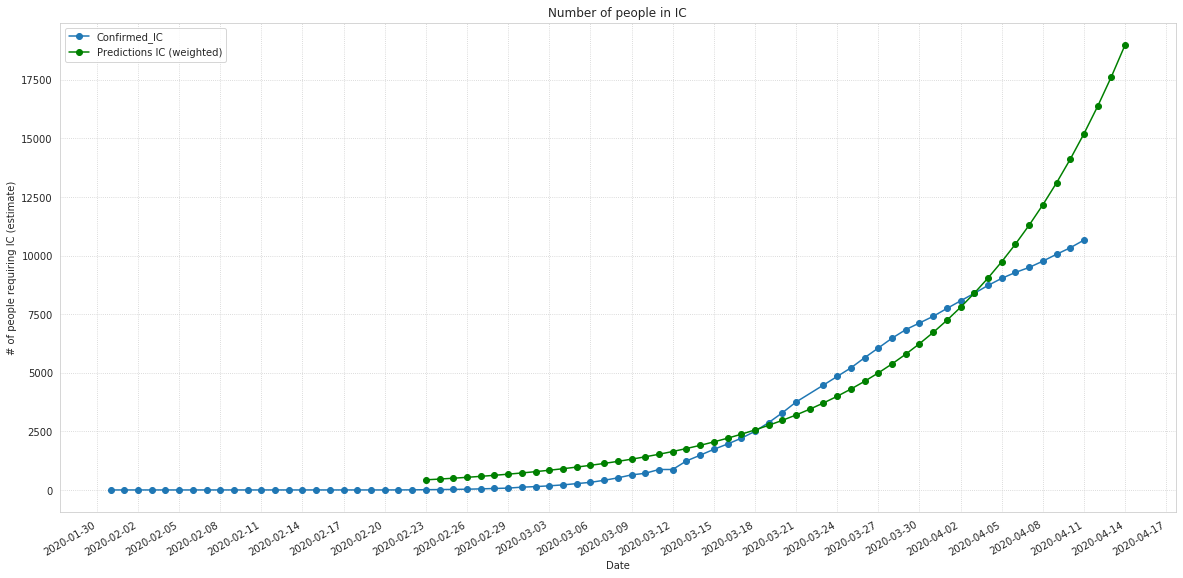

In [60]:
ax = plt.gca()

country_df.plot(x='Date', y=["Confirmed_IC"], figsize=(20,10), ax=ax, marker='o')
df_estimates.plot(x='Date', y=[
#     "Predictions IC (unweighted)", 
    "Predictions IC (weighted)"
], figsize=(20,10), ax=ax, marker='o', color="green")

# df_estimates.plot(x='Date', y=['IC caspacity (national)'], ax=ax, color='red', ls='--')
plt.title("Number of people in IC");

sns.set_style("whitegrid", {'grid.linestyle': ':'})

# ax.yaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))

ax.set_ylabel("# of people requiring IC (estimate)");

# ax.axhline(ESTIMATED_IC_CAPACITY, 0, 1, ls=':', color='red')

# ax.annotate('IC caspacity (national)', xy=("2020-02-23", ESTIMATED_IC_CAPACITY), xytext=("2020-02-16", ESTIMATED_IC_CAPACITY*0.9),
#             arrowprops=dict(facecolor='black', shrink=0.05));

# ax.legend([
#     "Estimated cases ({:d}%)".format(int(IC_coefficient*100)),
#     "Exponential fit",
#     "Better exponential fit",
# ])

plt.savefig(os.path.join(PLOTS_DIR, "IC_estimates.png"));

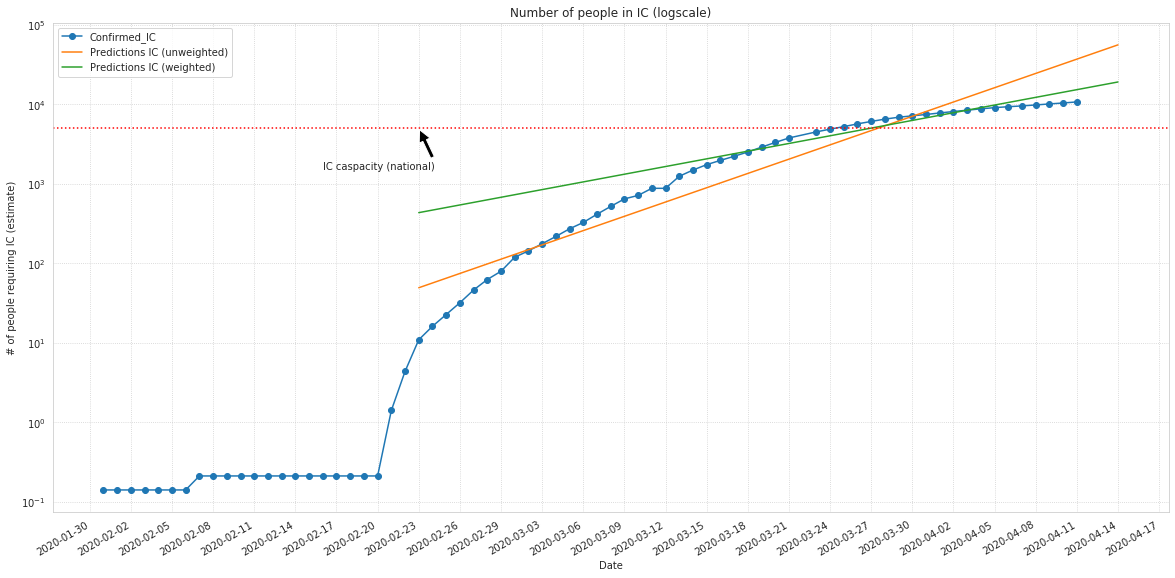

In [61]:
ax = plt.gca()

country_df.plot(x='Date', y=["Confirmed_IC"], figsize=(20,10), ax=ax, marker='o')
df_estimates.plot(x='Date', y=["Predictions IC (unweighted)", "Predictions IC (weighted)"], figsize=(20,10), ax=ax, logy=True)
# df_estimates.plot(x='Date', y=['IC caspacity (national)'], ax=ax, color='red', ls='--', logy=True)
plt.title("Number of people in IC (logscale)");

sns.set_style("whitegrid", {'grid.linestyle': ':'})

ax.axhline(ESTIMATED_IC_CAPACITY, 0, 1, ls=':', color='red')

ax.annotate('IC caspacity (national)', xy=("2020-02-23", 5000), xytext=("2020-02-16", 1500),
            arrowprops=dict(facecolor='black', shrink=0.05));

# ax.yaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))

ax.set_ylabel("# of people requiring IC (estimate)");

plt.savefig(os.path.join(PLOTS_DIR, "IC_estimates_logscale.png"));

## Countries comparison

Dates for Italy, Norway and Sweden have been manually aligned so that trends overlap.

In addition to that, data from Italy is truncated (data from the last 9 days is omitted) so that it doesn't make lines from other countries difficult to see.

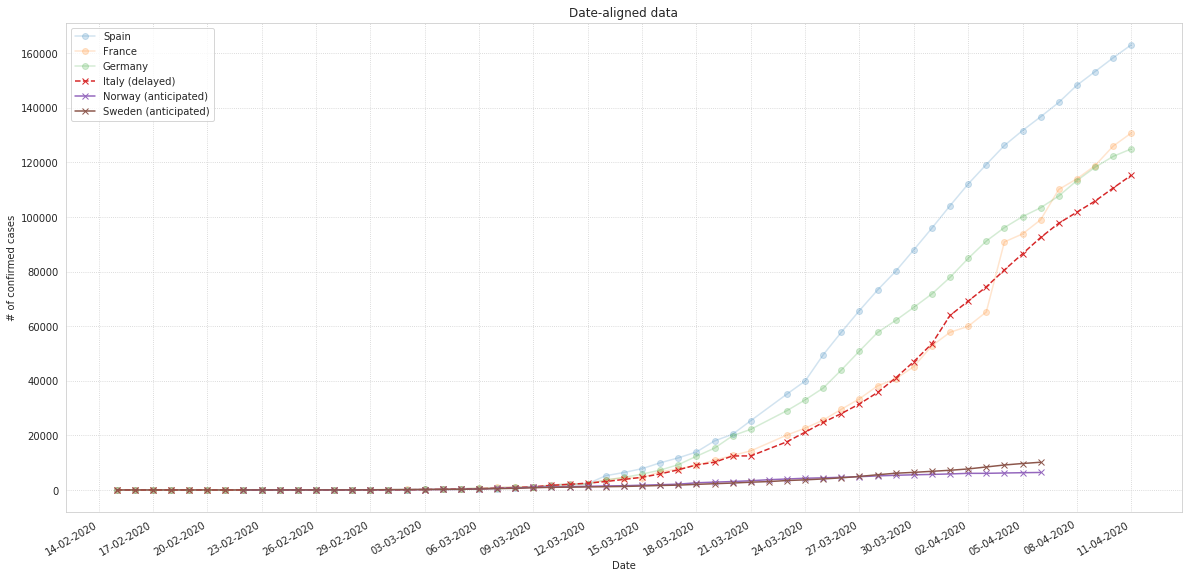

In [62]:
ax = plt.gca()

sns.set_style("whitegrid", {'grid.linestyle': ':'})
# ax.yaxis.set_major_locator(ticker.MultipleLocator(Y_GRID_TICK/5))
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))


countries_to_plot = [
#     "Italy",
    "Spain",
    "France",
    "Germany",
#     "Norway",
#     "Sweden",
]

for cc in countries_to_plot:
    c_df = get_country_df(world_df, cc)
    c_df = c_df[c_df['Date'] > datetime(2020, 2,14).date()]
    
    c_df.plot(x='Date', y=["Confirmed"], figsize=(20,10), ax=ax, marker='o', alpha=0.2)
    pass

italy_delayed = get_country_df(world_df, "Italy")
italy_delayed = italy_delayed.iloc[:-9,:]

spain_df = get_country_df(world_df, "Spain")
italy_delayed['Date'] = list(spain_df[spain_df['Date'] >= datetime(2020, 2, 9).date()]['Date'])

# Update date dynamically
end_date_skandinavia = (datetime.today() - timedelta(days=6)).date().strftime("%m-%d-%Y")
# end_date_skandinavia = (datetime.today() - timedelta(days=20)).date().strftime("%m-%d-%Y")

norway_anticipated = get_country_df(world_df, "Norway")
norway_anticipated['Date'] = pd.date_range(end=end_date_skandinavia, periods=len(norway_anticipated))

sweden_anticipated = get_country_df(world_df, "Sweden")
sweden_anticipated['Date'] = pd.date_range(end=end_date_skandinavia, periods=len(sweden_anticipated))

# Plot adjusted countries
italy_delayed = italy_delayed[italy_delayed['Date'] > datetime(2020, 2,14).date()]
italy_delayed.plot(x='Date', y=["Confirmed"], figsize=(20,10), ax=ax, marker='x', ls="--")

norway_anticipated = norway_anticipated[norway_anticipated['Date'] > "2020-02-14"]
sweden_anticipated = sweden_anticipated[sweden_anticipated['Date'] > "2020-02-14"]

norway_anticipated.plot(x='Date', y=["Confirmed"], figsize=(20,10), ax=ax, marker='x')
sweden_anticipated.plot(x='Date', y=["Confirmed"], figsize=(20,10), ax=ax, marker='x')

ax.legend(countries_to_plot + ['Italy (delayed)', 'Norway (anticipated)', 'Sweden (anticipated)'])
ax.set_ylabel("# of confirmed cases")

plt.title("Date-aligned data");

plt.savefig(os.path.join(PLOTS_DIR, "europe_aligned_dates.png"));

In [63]:
get_country_df(world_df, "Spain").tail()

Confirmed   Deaths  Recovered   Latitude  \
Country/Region Date                                                   
Spain          2020-04-07   141942.0  14045.0    43208.0  40.463667   
               2020-04-08   148220.0  14792.0    48021.0  40.463667   
               2020-04-09   153222.0  15447.0    52165.0  40.463667   
               2020-04-10   158273.0  16081.0    55668.0  40.463667   
               2020-04-11   163027.0  16606.0    59109.0  40.463667   

                           Longitude  FIPS        Lat    Long_   Active  \
Country/Region Date                                                       
Spain          2020-04-07   -3.74922   0.0  40.463667 -3.74922  84689.0   
               2020-04-08   -3.74922   0.0  40.463667 -3.74922  85407.0   
               2020-04-09   -3.74922   0.0  40.463667 -3.74922  85610.0   
               2020-04-10   -3.74922   0.0  40.463667 -3.74922  86524.0   
               2020-04-11   -3.74922   0.0  40.463667 -3.74922  87312.0   

                          Country/Region        Date  
Country/Region Date                                   
Spain          2020-04-07          Spain  2020-04-07  
               2020-04-08          Spain  2020-04-08  
               2020-04-09          Spain  2020-04-09  
               2020-04-10          Spain  2020-04-10  
               2020-04-11          Spain  2020-04-11

In [64]:

daily_increase_df = pd.DataFrame(columns=['Country', 'Date', 'Increase'])

N_data_points = 10

countries = [
    'Spain', 
    'France', 
    'Germany', 
    'Italy', 
    'Norway', 
    'Sweden',
]

for c in countries:

    c_df = get_country_df(world_df, c)

    for i in range(N_data_points):
        inc = c_df['Confirmed'][-N_data_points+i]/c_df['Confirmed'][-N_data_points+i-1]

        daily_increase_df_row = pd.DataFrame.from_dict({'Country': [c], 'Date': [c_df['Date'][-N_data_points+i]], 'Increase': [inc]})

        daily_increase_df = pd.concat((daily_increase_df, daily_increase_df_row), ignore_index=True)
        
daily_increase_df['Increase_p'] = (daily_increase_df['Increase'] - 1) * 100

/home/matteo/miniconda3/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7efbca1a8ed0> has a label of '_' which cannot be automatically added to the legend.
/home/matteo/miniconda3/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7efbca1ed990> has a label of '_' which cannot be automatically added to the legend.
/home/matteo/miniconda3/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7efbca201b50> has a label of '_' which cannot be automatically added to the legend.
/home/matteo/miniconda3/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7efbcc454f90> has a label of '_' which cannot be automatically added to the legend.
/home/matteo/miniconda3/envs/jupyter/lib/python3.7/site-

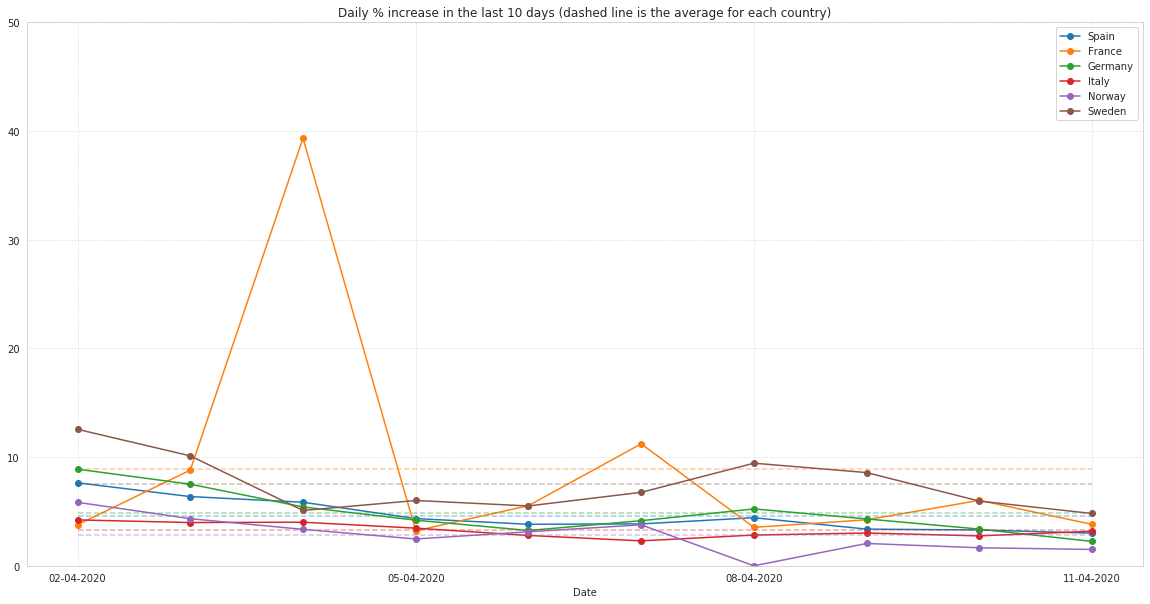

In [65]:
ax = plt.gca()

sns.set_style("whitegrid", {'grid.linestyle': ':'})
# ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))


legend_strings = list()


for c in countries:
    
    daily_increase_df_country = daily_increase_df[daily_increase_df['Country'] == c].copy()
    
    daily_increase_df_country['Average'] = daily_increase_df_country['Increase'].mean()
    daily_increase_df_country['Average_p'] = daily_increase_df_country['Increase_p'].mean()
    
    # Plot daily increase
    daily_increase_df_country.plot(x='Date', y=["Increase_p"], figsize=(20,10), ax=ax, marker='o')
    
#     ax.lines[-1].set_label(c)
    
    # Plot mean (no label)
    
    daily_increase_df_country.plot(
        x='Date', y=["Average_p"], 
        figsize=(20,10), ax=ax, ls="--", alpha=0.4, color=ax.lines[-1].get_color(), legend=False)
    
#     print(dir(ax.lines[-1]))
    
#     ax.lines[-1].set_label("_")
    
#     legend_strings.extend([c, f"{c} (average)"])
    legend_strings.extend([c, "_"])
    
ax.legend(legend_strings)
# ax.legend(countries)

# Limit y range to increase visibility
# ax.set_ylim(1, 2.2);
ax.set_ylim(0, 50);

ax.set_title("Daily % increase in the last 10 days (dashed line is the average for each country)");
plt.savefig(os.path.join(PLOTS_DIR, "europe_daily_increase_10days.png"));